In [10]:
import os
import numpy as np
import pytorch_lightning as pl
import torch.nn as nn
import torch
from data import LabeledDataset
from torch.utils.data import DataLoader
from CFS_SG import CFS_SG
import numpy as np
from numpy.linalg import svd, pinv
import matplotlib.pyplot as plt

In [2]:
def compute_leverage_scores(V, k):
    leverage_scores = np.sum(V[:k, :]**2, axis=0)
    return leverage_scores

def scores(A, k):
    U, S, Vt = svd(A, full_matrices=False)
    column_scores = compute_leverage_scores(Vt, k)
    row_scores = compute_leverage_scores(U.T, k)
    
    return column_scores, row_scores

def ccur(X, Y, k, top_selected, epsilon = 1e-6):
    leverage_scores_X, _ = scores(X, k)
    leverage_scores_Y, _ = scores(Y, k)
    
    ratios =(leverage_scores_X) / (leverage_scores_Y)
    
    top_k_indices = np.argsort(-ratios)[:top_selected]
    
    return top_k_indices, ratios[top_k_indices], ratios


In [13]:
def generate_data(n, m, p, k):
    Z_shared = np.random.normal(size=(n, k))
    Z_shared[np.abs(Z_shared) < 1.8] = 0

    Z_unique = np.random.normal(size=(n, k))
    Z_unique[np.abs(Z_unique) < 1.8] = 0

    Z_bg = np.random.normal(size=(m, k))
    Z_bg[np.abs(Z_bg) < 1.8] = 0

    V = np.random.normal(size=(k, p))  # shared loadings
    V[np.abs(V) < 1.8] = 0

    W = np.random.normal(size=(k, p))  # foreground-specific loadings
    W[np.abs(W) < 1.8] = 0

    background = Z_bg @ V + np.random.normal(0, 1, size=(m, p))
    foreground = Z_shared @ V + Z_unique @ W + np.random.normal(0, 1, size=(n, p))

    return background, foreground, W, V, Z_unique, Z_shared, Z_bg


In [14]:
def compute_leverage_scores(V, k):
    return np.sum(V[:k, :] ** 2, axis=0)

def scores(A, k):
    U, S, Vt = svd(A, full_matrices=False)
    return compute_leverage_scores(Vt, k), compute_leverage_scores(U.T, k)

def cols_ranking_cur(F, k):
    col_scores, _ = scores(F, k)
    return np.argsort(-col_scores)          # descending order

def cols_ranking_ccur(F, B, k, eps=1e-12):
    col_F, _ = scores(F, k)
    col_B, _ = scores(B, k)
    ratio = col_F / (col_B+eps)
    return np.argsort(-ratio)               # descending order

def cols_ranking_cpca(F, B):
    constrastive_cov = np.cov(F, rowvar=False) - np.cov(B, rowvar=False)
    eigenvalues, eigenvectors = np.linalg.eig(constrastive_cov)
    first_pc = eigenvectors[:, np.argmax(eigenvalues)]
    return np.argsort(-np.abs(first_pc))
    
def cumulative_hits(order, target_set):
    return np.cumsum(np.isin(order, target_set).astype(int))

In [15]:
def compare_column_accumulation(n=500, m=500, p=100, f=5, k=10, n_sim=100):

    cum_W = {method: np.zeros((n_sim, p)) for method in ['CUR', 'CCUR', 'CPCA', 'CFS']}
    cum_V = {method: np.zeros((n_sim, p)) for method in ['CUR', 'CCUR', 'CPCA', 'CFS']}

    for s in range(n_sim):
        B, F, W, V, Z_unique, Z_shared, Z_bg = generate_data(n, m, p, f)
        W_set = np.where(np.any(W != 0, axis=0))[0]
        V_set = np.where(np.any(V != 0, axis=0))[0]

        # ---- CUR ----
        rank_cur = cols_ranking_cur(F, k)
        cum_W['CUR'][s] = cumulative_hits(rank_cur, W_set)
        cum_V['CUR'][s] = cumulative_hits(rank_cur, V_set)

        # ---- CCUR ----
        rank_ccur = cols_ranking_ccur(F, B, k)
        cum_W['CCUR'][s] = cumulative_hits(rank_ccur, W_set)
        cum_V['CCUR'][s] = cumulative_hits(rank_ccur, V_set)

        # ---- CPCA ----
        rank_cpca = cols_ranking_cpca(F, B)
        cum_W['CPCA'][s] = cumulative_hits(rank_cpca, W_set)
        cum_V['CPCA'][s] = cumulative_hits(rank_cpca, V_set)

        # ---- CFS ----
        input_size = F.shape[1]
        output_size = B.shape[1]
        batch_size = 128

        labels_train = np.concatenate([np.zeros(B.shape[0]), np.ones(F.shape[0])])
        data_train = np.concatenate([B, F])
        data_tensor = torch.from_numpy(data_train).float()
        label_tensor = torch.from_numpy(labels_train).float()

        dataset = LabeledDataset(data_tensor.numpy(), label_tensor.numpy())
        loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

        model = CFS_SG(
            input_size=input_size,
            output_size=output_size,
            hidden=[512, 512],
            k_prime=20,
            lam=0.15,
            lr=1e-3,
            loss_fn=nn.MSELoss()
        )

        trainer = pl.Trainer(max_epochs=10, accelerator='gpu', devices=1,
                             enable_checkpointing=False, logger=False)
        trainer.fit(model, loader)

        cfs_cols = model.get_inds(p)
        cum_W['CFS'][s] = cumulative_hits(cfs_cols, W_set)
        cum_V['CFS'][s] = cumulative_hits(cfs_cols, V_set)

    # ---- Mean curves ----
    mean_W = {method: cum_W[method].mean(axis=0) for method in cum_W}
    mean_S = {method: cum_V[method].mean(axis=0) for method in cum_V}

    return (
        mean_W['CCUR'], mean_W['CUR'], mean_S['CUR'], mean_S['CCUR'],
        cum_W['CCUR'], cum_W['CUR'], cum_V['CUR'], cum_V['CCUR'],
        mean_W['CPCA'], mean_S['CPCA'],
        cum_W['CPCA'], cum_V['CPCA'],
        mean_W['CFS'], mean_S['CFS'],
        cum_W['CFS'], cum_V['CFS']
    )


In [16]:
import random
random.seed(42)

(
    mean_W_ccur, mean_W_cur, mean_V_cur, mean_V_ccur,
    cum_W_ccur, cum_W_cur, cum_V_cur, cum_V_ccur,
    mean_W_cpca, mean_V_cpca,
    cum_W_cpca, cum_V_cpca,
    mean_W_cfs, mean_V_cfs,
    cum_W_cfs, cum_V_cfs
) = compare_column_accumulation(n_sim=100)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                   | Type       | Params | Mode 
--------------------------------------------------------------
0 | background_input_layer | Sequential | 15.5 K | train
1 | fc                     | Sequential | 375 K  | train
2 | loss_fn                | MSELoss    | 0      | train
  | other params           | n/a        | 100    | n/a  
--------------------------------------------------------------
391 K     Trainable params
0         Non-trainable params
391 K     Total params
1.566     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode
SLURM auto-requeueing enabled. Setting signal handlers.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                   | Type       | Params | Mode 
--------------------------------------------------------------
0 | background_input_layer | Sequential | 15.5 K | train
1 | fc                     | Sequential | 375 K  | train
2 | loss_fn                | MSELoss    | 0      | train
  | other params           | n/a        | 100    | n/a  
--------------------------------------------------------------
391 K     Trainable params
0         Non-trainable params
391 K     Total params
1.566     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode
SLURM auto-requeueing enabled. Setting signal handlers.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                   | Type       | Params | Mode 
--------------------------------------------------------------
0 | background_input_layer | Sequential | 15.5 K | train
1 | fc                     | Sequential | 375 K  | train
2 | loss_fn                | MSELoss    | 0      | train
  | other params           | n/a        | 100    | n/a  
--------------------------------------------------------------
391 K     Trainable params
0         Non-trainable params
391 K     Total params
1.566     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode
SLURM auto-requeueing enabled. Setting signal handlers.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                   | Type       | Params | Mode 
--------------------------------------------------------------
0 | background_input_layer | Sequential | 15.5 K | train
1 | fc                     | Sequential | 375 K  | train
2 | loss_fn                | MSELoss    | 0      | train
  | other params           | n/a        | 100    | n/a  
--------------------------------------------------------------
391 K     Trainable params
0         Non-trainable params
391 K     Total params
1.566     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode
SLURM auto-requeueing enabled. Setting signal handlers.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                   | Type       | Params | Mode 
--------------------------------------------------------------
0 | background_input_layer | Sequential | 15.5 K | train
1 | fc                     | Sequential | 375 K  | train
2 | loss_fn                | MSELoss    | 0      | train
  | other params           | n/a        | 100    | n/a  
--------------------------------------------------------------
391 K     Trainable params
0         Non-trainable params
391 K     Total params
1.566     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode
SLURM auto-requeueing enabled. Setting signal handlers.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                   | Type       | Params | Mode 
--------------------------------------------------------------
0 | background_input_layer | Sequential | 15.5 K | train
1 | fc                     | Sequential | 375 K  | train
2 | loss_fn                | MSELoss    | 0      | train
  | other params           | n/a        | 100    | n/a  
--------------------------------------------------------------
391 K     Trainable params
0         Non-trainable params
391 K     Total params
1.566     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode
SLURM auto-requeueing enabled. Setting signal handlers.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                   | Type       | Params | Mode 
--------------------------------------------------------------
0 | background_input_layer | Sequential | 15.5 K | train
1 | fc                     | Sequential | 375 K  | train
2 | loss_fn                | MSELoss    | 0      | train
  | other params           | n/a        | 100    | n/a  
--------------------------------------------------------------
391 K     Trainable params
0         Non-trainable params
391 K     Total params
1.566     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode
SLURM auto-requeueing enabled. Setting signal handlers.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                   | Type       | Params | Mode 
--------------------------------------------------------------
0 | background_input_layer | Sequential | 15.5 K | train
1 | fc                     | Sequential | 375 K  | train
2 | loss_fn                | MSELoss    | 0      | train
  | other params           | n/a        | 100    | n/a  
--------------------------------------------------------------
391 K     Trainable params
0         Non-trainable params
391 K     Total params
1.566     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode
SLURM auto-requeueing enabled. Setting signal handlers.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                   | Type       | Params | Mode 
--------------------------------------------------------------
0 | background_input_layer | Sequential | 15.5 K | train
1 | fc                     | Sequential | 375 K  | train
2 | loss_fn                | MSELoss    | 0      | train
  | other params           | n/a        | 100    | n/a  
--------------------------------------------------------------
391 K     Trainable params
0         Non-trainable params
391 K     Total params
1.566     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode
SLURM auto-requeueing enabled. Setting signal handlers.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                   | Type       | Params | Mode 
--------------------------------------------------------------
0 | background_input_layer | Sequential | 15.5 K | train
1 | fc                     | Sequential | 375 K  | train
2 | loss_fn                | MSELoss    | 0      | train
  | other params           | n/a        | 100    | n/a  
--------------------------------------------------------------
391 K     Trainable params
0         Non-trainable params
391 K     Total params
1.566     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode
SLURM auto-requeueing enabled. Setting signal handlers.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                   | Type       | Params | Mode 
--------------------------------------------------------------
0 | background_input_layer | Sequential | 15.5 K | train
1 | fc                     | Sequential | 375 K  | train
2 | loss_fn                | MSELoss    | 0      | train
  | other params           | n/a        | 100    | n/a  
--------------------------------------------------------------
391 K     Trainable params
0         Non-trainable params
391 K     Total params
1.566     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode
SLURM auto-requeueing enabled. Setting signal handlers.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                   | Type       | Params | Mode 
--------------------------------------------------------------
0 | background_input_layer | Sequential | 15.5 K | train
1 | fc                     | Sequential | 375 K  | train
2 | loss_fn                | MSELoss    | 0      | train
  | other params           | n/a        | 100    | n/a  
--------------------------------------------------------------
391 K     Trainable params
0         Non-trainable params
391 K     Total params
1.566     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode
SLURM auto-requeueing enabled. Setting signal handlers.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                   | Type       | Params | Mode 
--------------------------------------------------------------
0 | background_input_layer | Sequential | 15.5 K | train
1 | fc                     | Sequential | 375 K  | train
2 | loss_fn                | MSELoss    | 0      | train
  | other params           | n/a        | 100    | n/a  
--------------------------------------------------------------
391 K     Trainable params
0         Non-trainable params
391 K     Total params
1.566     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode
SLURM auto-requeueing enabled. Setting signal handlers.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                   | Type       | Params | Mode 
--------------------------------------------------------------
0 | background_input_layer | Sequential | 15.5 K | train
1 | fc                     | Sequential | 375 K  | train
2 | loss_fn                | MSELoss    | 0      | train
  | other params           | n/a        | 100    | n/a  
--------------------------------------------------------------
391 K     Trainable params
0         Non-trainable params
391 K     Total params
1.566     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode
SLURM auto-requeueing enabled. Setting signal handlers.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                   | Type       | Params | Mode 
--------------------------------------------------------------
0 | background_input_layer | Sequential | 15.5 K | train
1 | fc                     | Sequential | 375 K  | train
2 | loss_fn                | MSELoss    | 0      | train
  | other params           | n/a        | 100    | n/a  
--------------------------------------------------------------
391 K     Trainable params
0         Non-trainable params
391 K     Total params
1.566     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode
SLURM auto-requeueing enabled. Setting signal handlers.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                   | Type       | Params | Mode 
--------------------------------------------------------------
0 | background_input_layer | Sequential | 15.5 K | train
1 | fc                     | Sequential | 375 K  | train
2 | loss_fn                | MSELoss    | 0      | train
  | other params           | n/a        | 100    | n/a  
--------------------------------------------------------------
391 K     Trainable params
0         Non-trainable params
391 K     Total params
1.566     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode
SLURM auto-requeueing enabled. Setting signal handlers.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                   | Type       | Params | Mode 
--------------------------------------------------------------
0 | background_input_layer | Sequential | 15.5 K | train
1 | fc                     | Sequential | 375 K  | train
2 | loss_fn                | MSELoss    | 0      | train
  | other params           | n/a        | 100    | n/a  
--------------------------------------------------------------
391 K     Trainable params
0         Non-trainable params
391 K     Total params
1.566     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode
SLURM auto-requeueing enabled. Setting signal handlers.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                   | Type       | Params | Mode 
--------------------------------------------------------------
0 | background_input_layer | Sequential | 15.5 K | train
1 | fc                     | Sequential | 375 K  | train
2 | loss_fn                | MSELoss    | 0      | train
  | other params           | n/a        | 100    | n/a  
--------------------------------------------------------------
391 K     Trainable params
0         Non-trainable params
391 K     Total params
1.566     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode
SLURM auto-requeueing enabled. Setting signal handlers.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                   | Type       | Params | Mode 
--------------------------------------------------------------
0 | background_input_layer | Sequential | 15.5 K | train
1 | fc                     | Sequential | 375 K  | train
2 | loss_fn                | MSELoss    | 0      | train
  | other params           | n/a        | 100    | n/a  
--------------------------------------------------------------
391 K     Trainable params
0         Non-trainable params
391 K     Total params
1.566     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode
SLURM auto-requeueing enabled. Setting signal handlers.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                   | Type       | Params | Mode 
--------------------------------------------------------------
0 | background_input_layer | Sequential | 15.5 K | train
1 | fc                     | Sequential | 375 K  | train
2 | loss_fn                | MSELoss    | 0      | train
  | other params           | n/a        | 100    | n/a  
--------------------------------------------------------------
391 K     Trainable params
0         Non-trainable params
391 K     Total params
1.566     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode
SLURM auto-requeueing enabled. Setting signal handlers.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                   | Type       | Params | Mode 
--------------------------------------------------------------
0 | background_input_layer | Sequential | 15.5 K | train
1 | fc                     | Sequential | 375 K  | train
2 | loss_fn                | MSELoss    | 0      | train
  | other params           | n/a        | 100    | n/a  
--------------------------------------------------------------
391 K     Trainable params
0         Non-trainable params
391 K     Total params
1.566     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode
SLURM auto-requeueing enabled. Setting signal handlers.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                   | Type       | Params | Mode 
--------------------------------------------------------------
0 | background_input_layer | Sequential | 15.5 K | train
1 | fc                     | Sequential | 375 K  | train
2 | loss_fn                | MSELoss    | 0      | train
  | other params           | n/a        | 100    | n/a  
--------------------------------------------------------------
391 K     Trainable params
0         Non-trainable params
391 K     Total params
1.566     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode
SLURM auto-requeueing enabled. Setting signal handlers.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                   | Type       | Params | Mode 
--------------------------------------------------------------
0 | background_input_layer | Sequential | 15.5 K | train
1 | fc                     | Sequential | 375 K  | train
2 | loss_fn                | MSELoss    | 0      | train
  | other params           | n/a        | 100    | n/a  
--------------------------------------------------------------
391 K     Trainable params
0         Non-trainable params
391 K     Total params
1.566     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode
SLURM auto-requeueing enabled. Setting signal handlers.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                   | Type       | Params | Mode 
--------------------------------------------------------------
0 | background_input_layer | Sequential | 15.5 K | train
1 | fc                     | Sequential | 375 K  | train
2 | loss_fn                | MSELoss    | 0      | train
  | other params           | n/a        | 100    | n/a  
--------------------------------------------------------------
391 K     Trainable params
0         Non-trainable params
391 K     Total params
1.566     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode
SLURM auto-requeueing enabled. Setting signal handlers.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                   | Type       | Params | Mode 
--------------------------------------------------------------
0 | background_input_layer | Sequential | 15.5 K | train
1 | fc                     | Sequential | 375 K  | train
2 | loss_fn                | MSELoss    | 0      | train
  | other params           | n/a        | 100    | n/a  
--------------------------------------------------------------
391 K     Trainable params
0         Non-trainable params
391 K     Total params
1.566     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode
SLURM auto-requeueing enabled. Setting signal handlers.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                   | Type       | Params | Mode 
--------------------------------------------------------------
0 | background_input_layer | Sequential | 15.5 K | train
1 | fc                     | Sequential | 375 K  | train
2 | loss_fn                | MSELoss    | 0      | train
  | other params           | n/a        | 100    | n/a  
--------------------------------------------------------------
391 K     Trainable params
0         Non-trainable params
391 K     Total params
1.566     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode
SLURM auto-requeueing enabled. Setting signal handlers.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                   | Type       | Params | Mode 
--------------------------------------------------------------
0 | background_input_layer | Sequential | 15.5 K | train
1 | fc                     | Sequential | 375 K  | train
2 | loss_fn                | MSELoss    | 0      | train
  | other params           | n/a        | 100    | n/a  
--------------------------------------------------------------
391 K     Trainable params
0         Non-trainable params
391 K     Total params
1.566     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode
SLURM auto-requeueing enabled. Setting signal handlers.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                   | Type       | Params | Mode 
--------------------------------------------------------------
0 | background_input_layer | Sequential | 15.5 K | train
1 | fc                     | Sequential | 375 K  | train
2 | loss_fn                | MSELoss    | 0      | train
  | other params           | n/a        | 100    | n/a  
--------------------------------------------------------------
391 K     Trainable params
0         Non-trainable params
391 K     Total params
1.566     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode
SLURM auto-requeueing enabled. Setting signal handlers.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                   | Type       | Params | Mode 
--------------------------------------------------------------
0 | background_input_layer | Sequential | 15.5 K | train
1 | fc                     | Sequential | 375 K  | train
2 | loss_fn                | MSELoss    | 0      | train
  | other params           | n/a        | 100    | n/a  
--------------------------------------------------------------
391 K     Trainable params
0         Non-trainable params
391 K     Total params
1.566     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode
SLURM auto-requeueing enabled. Setting signal handlers.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                   | Type       | Params | Mode 
--------------------------------------------------------------
0 | background_input_layer | Sequential | 15.5 K | train
1 | fc                     | Sequential | 375 K  | train
2 | loss_fn                | MSELoss    | 0      | train
  | other params           | n/a        | 100    | n/a  
--------------------------------------------------------------
391 K     Trainable params
0         Non-trainable params
391 K     Total params
1.566     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode
SLURM auto-requeueing enabled. Setting signal handlers.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                   | Type       | Params | Mode 
--------------------------------------------------------------
0 | background_input_layer | Sequential | 15.5 K | train
1 | fc                     | Sequential | 375 K  | train
2 | loss_fn                | MSELoss    | 0      | train
  | other params           | n/a        | 100    | n/a  
--------------------------------------------------------------
391 K     Trainable params
0         Non-trainable params
391 K     Total params
1.566     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode
SLURM auto-requeueing enabled. Setting signal handlers.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                   | Type       | Params | Mode 
--------------------------------------------------------------
0 | background_input_layer | Sequential | 15.5 K | train
1 | fc                     | Sequential | 375 K  | train
2 | loss_fn                | MSELoss    | 0      | train
  | other params           | n/a        | 100    | n/a  
--------------------------------------------------------------
391 K     Trainable params
0         Non-trainable params
391 K     Total params
1.566     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode
SLURM auto-requeueing enabled. Setting signal handlers.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                   | Type       | Params | Mode 
--------------------------------------------------------------
0 | background_input_layer | Sequential | 15.5 K | train
1 | fc                     | Sequential | 375 K  | train
2 | loss_fn                | MSELoss    | 0      | train
  | other params           | n/a        | 100    | n/a  
--------------------------------------------------------------
391 K     Trainable params
0         Non-trainable params
391 K     Total params
1.566     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode
SLURM auto-requeueing enabled. Setting signal handlers.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                   | Type       | Params | Mode 
--------------------------------------------------------------
0 | background_input_layer | Sequential | 15.5 K | train
1 | fc                     | Sequential | 375 K  | train
2 | loss_fn                | MSELoss    | 0      | train
  | other params           | n/a        | 100    | n/a  
--------------------------------------------------------------
391 K     Trainable params
0         Non-trainable params
391 K     Total params
1.566     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode
SLURM auto-requeueing enabled. Setting signal handlers.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                   | Type       | Params | Mode 
--------------------------------------------------------------
0 | background_input_layer | Sequential | 15.5 K | train
1 | fc                     | Sequential | 375 K  | train
2 | loss_fn                | MSELoss    | 0      | train
  | other params           | n/a        | 100    | n/a  
--------------------------------------------------------------
391 K     Trainable params
0         Non-trainable params
391 K     Total params
1.566     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode
SLURM auto-requeueing enabled. Setting signal handlers.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                   | Type       | Params | Mode 
--------------------------------------------------------------
0 | background_input_layer | Sequential | 15.5 K | train
1 | fc                     | Sequential | 375 K  | train
2 | loss_fn                | MSELoss    | 0      | train
  | other params           | n/a        | 100    | n/a  
--------------------------------------------------------------
391 K     Trainable params
0         Non-trainable params
391 K     Total params
1.566     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode
SLURM auto-requeueing enabled. Setting signal handlers.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                   | Type       | Params | Mode 
--------------------------------------------------------------
0 | background_input_layer | Sequential | 15.5 K | train
1 | fc                     | Sequential | 375 K  | train
2 | loss_fn                | MSELoss    | 0      | train
  | other params           | n/a        | 100    | n/a  
--------------------------------------------------------------
391 K     Trainable params
0         Non-trainable params
391 K     Total params
1.566     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode
SLURM auto-requeueing enabled. Setting signal handlers.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                   | Type       | Params | Mode 
--------------------------------------------------------------
0 | background_input_layer | Sequential | 15.5 K | train
1 | fc                     | Sequential | 375 K  | train
2 | loss_fn                | MSELoss    | 0      | train
  | other params           | n/a        | 100    | n/a  
--------------------------------------------------------------
391 K     Trainable params
0         Non-trainable params
391 K     Total params
1.566     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode
SLURM auto-requeueing enabled. Setting signal handlers.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                   | Type       | Params | Mode 
--------------------------------------------------------------
0 | background_input_layer | Sequential | 15.5 K | train
1 | fc                     | Sequential | 375 K  | train
2 | loss_fn                | MSELoss    | 0      | train
  | other params           | n/a        | 100    | n/a  
--------------------------------------------------------------
391 K     Trainable params
0         Non-trainable params
391 K     Total params
1.566     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode
SLURM auto-requeueing enabled. Setting signal handlers.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                   | Type       | Params | Mode 
--------------------------------------------------------------
0 | background_input_layer | Sequential | 15.5 K | train
1 | fc                     | Sequential | 375 K  | train
2 | loss_fn                | MSELoss    | 0      | train
  | other params           | n/a        | 100    | n/a  
--------------------------------------------------------------
391 K     Trainable params
0         Non-trainable params
391 K     Total params
1.566     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode
SLURM auto-requeueing enabled. Setting signal handlers.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                   | Type       | Params | Mode 
--------------------------------------------------------------
0 | background_input_layer | Sequential | 15.5 K | train
1 | fc                     | Sequential | 375 K  | train
2 | loss_fn                | MSELoss    | 0      | train
  | other params           | n/a        | 100    | n/a  
--------------------------------------------------------------
391 K     Trainable params
0         Non-trainable params
391 K     Total params
1.566     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode
SLURM auto-requeueing enabled. Setting signal handlers.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                   | Type       | Params | Mode 
--------------------------------------------------------------
0 | background_input_layer | Sequential | 15.5 K | train
1 | fc                     | Sequential | 375 K  | train
2 | loss_fn                | MSELoss    | 0      | train
  | other params           | n/a        | 100    | n/a  
--------------------------------------------------------------
391 K     Trainable params
0         Non-trainable params
391 K     Total params
1.566     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode
SLURM auto-requeueing enabled. Setting signal handlers.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                   | Type       | Params | Mode 
--------------------------------------------------------------
0 | background_input_layer | Sequential | 15.5 K | train
1 | fc                     | Sequential | 375 K  | train
2 | loss_fn                | MSELoss    | 0      | train
  | other params           | n/a        | 100    | n/a  
--------------------------------------------------------------
391 K     Trainable params
0         Non-trainable params
391 K     Total params
1.566     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode
SLURM auto-requeueing enabled. Setting signal handlers.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                   | Type       | Params | Mode 
--------------------------------------------------------------
0 | background_input_layer | Sequential | 15.5 K | train
1 | fc                     | Sequential | 375 K  | train
2 | loss_fn                | MSELoss    | 0      | train
  | other params           | n/a        | 100    | n/a  
--------------------------------------------------------------
391 K     Trainable params
0         Non-trainable params
391 K     Total params
1.566     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode
SLURM auto-requeueing enabled. Setting signal handlers.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                   | Type       | Params | Mode 
--------------------------------------------------------------
0 | background_input_layer | Sequential | 15.5 K | train
1 | fc                     | Sequential | 375 K  | train
2 | loss_fn                | MSELoss    | 0      | train
  | other params           | n/a        | 100    | n/a  
--------------------------------------------------------------
391 K     Trainable params
0         Non-trainable params
391 K     Total params
1.566     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode
SLURM auto-requeueing enabled. Setting signal handlers.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                   | Type       | Params | Mode 
--------------------------------------------------------------
0 | background_input_layer | Sequential | 15.5 K | train
1 | fc                     | Sequential | 375 K  | train
2 | loss_fn                | MSELoss    | 0      | train
  | other params           | n/a        | 100    | n/a  
--------------------------------------------------------------
391 K     Trainable params
0         Non-trainable params
391 K     Total params
1.566     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode
SLURM auto-requeueing enabled. Setting signal handlers.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                   | Type       | Params | Mode 
--------------------------------------------------------------
0 | background_input_layer | Sequential | 15.5 K | train
1 | fc                     | Sequential | 375 K  | train
2 | loss_fn                | MSELoss    | 0      | train
  | other params           | n/a        | 100    | n/a  
--------------------------------------------------------------
391 K     Trainable params
0         Non-trainable params
391 K     Total params
1.566     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode
SLURM auto-requeueing enabled. Setting signal handlers.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                   | Type       | Params | Mode 
--------------------------------------------------------------
0 | background_input_layer | Sequential | 15.5 K | train
1 | fc                     | Sequential | 375 K  | train
2 | loss_fn                | MSELoss    | 0      | train
  | other params           | n/a        | 100    | n/a  
--------------------------------------------------------------
391 K     Trainable params
0         Non-trainable params
391 K     Total params
1.566     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode
SLURM auto-requeueing enabled. Setting signal handlers.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                   | Type       | Params | Mode 
--------------------------------------------------------------
0 | background_input_layer | Sequential | 15.5 K | train
1 | fc                     | Sequential | 375 K  | train
2 | loss_fn                | MSELoss    | 0      | train
  | other params           | n/a        | 100    | n/a  
--------------------------------------------------------------
391 K     Trainable params
0         Non-trainable params
391 K     Total params
1.566     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode
SLURM auto-requeueing enabled. Setting signal handlers.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                   | Type       | Params | Mode 
--------------------------------------------------------------
0 | background_input_layer | Sequential | 15.5 K | train
1 | fc                     | Sequential | 375 K  | train
2 | loss_fn                | MSELoss    | 0      | train
  | other params           | n/a        | 100    | n/a  
--------------------------------------------------------------
391 K     Trainable params
0         Non-trainable params
391 K     Total params
1.566     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode
SLURM auto-requeueing enabled. Setting signal handlers.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                   | Type       | Params | Mode 
--------------------------------------------------------------
0 | background_input_layer | Sequential | 15.5 K | train
1 | fc                     | Sequential | 375 K  | train
2 | loss_fn                | MSELoss    | 0      | train
  | other params           | n/a        | 100    | n/a  
--------------------------------------------------------------
391 K     Trainable params
0         Non-trainable params
391 K     Total params
1.566     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode
SLURM auto-requeueing enabled. Setting signal handlers.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                   | Type       | Params | Mode 
--------------------------------------------------------------
0 | background_input_layer | Sequential | 15.5 K | train
1 | fc                     | Sequential | 375 K  | train
2 | loss_fn                | MSELoss    | 0      | train
  | other params           | n/a        | 100    | n/a  
--------------------------------------------------------------
391 K     Trainable params
0         Non-trainable params
391 K     Total params
1.566     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode
SLURM auto-requeueing enabled. Setting signal handlers.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                   | Type       | Params | Mode 
--------------------------------------------------------------
0 | background_input_layer | Sequential | 15.5 K | train
1 | fc                     | Sequential | 375 K  | train
2 | loss_fn                | MSELoss    | 0      | train
  | other params           | n/a        | 100    | n/a  
--------------------------------------------------------------
391 K     Trainable params
0         Non-trainable params
391 K     Total params
1.566     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode
SLURM auto-requeueing enabled. Setting signal handlers.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                   | Type       | Params | Mode 
--------------------------------------------------------------
0 | background_input_layer | Sequential | 15.5 K | train
1 | fc                     | Sequential | 375 K  | train
2 | loss_fn                | MSELoss    | 0      | train
  | other params           | n/a        | 100    | n/a  
--------------------------------------------------------------
391 K     Trainable params
0         Non-trainable params
391 K     Total params
1.566     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode
SLURM auto-requeueing enabled. Setting signal handlers.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                   | Type       | Params | Mode 
--------------------------------------------------------------
0 | background_input_layer | Sequential | 15.5 K | train
1 | fc                     | Sequential | 375 K  | train
2 | loss_fn                | MSELoss    | 0      | train
  | other params           | n/a        | 100    | n/a  
--------------------------------------------------------------
391 K     Trainable params
0         Non-trainable params
391 K     Total params
1.566     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode
SLURM auto-requeueing enabled. Setting signal handlers.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                   | Type       | Params | Mode 
--------------------------------------------------------------
0 | background_input_layer | Sequential | 15.5 K | train
1 | fc                     | Sequential | 375 K  | train
2 | loss_fn                | MSELoss    | 0      | train
  | other params           | n/a        | 100    | n/a  
--------------------------------------------------------------
391 K     Trainable params
0         Non-trainable params
391 K     Total params
1.566     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode
SLURM auto-requeueing enabled. Setting signal handlers.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                   | Type       | Params | Mode 
--------------------------------------------------------------
0 | background_input_layer | Sequential | 15.5 K | train
1 | fc                     | Sequential | 375 K  | train
2 | loss_fn                | MSELoss    | 0      | train
  | other params           | n/a        | 100    | n/a  
--------------------------------------------------------------
391 K     Trainable params
0         Non-trainable params
391 K     Total params
1.566     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode
SLURM auto-requeueing enabled. Setting signal handlers.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                   | Type       | Params | Mode 
--------------------------------------------------------------
0 | background_input_layer | Sequential | 15.5 K | train
1 | fc                     | Sequential | 375 K  | train
2 | loss_fn                | MSELoss    | 0      | train
  | other params           | n/a        | 100    | n/a  
--------------------------------------------------------------
391 K     Trainable params
0         Non-trainable params
391 K     Total params
1.566     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode
SLURM auto-requeueing enabled. Setting signal handlers.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                   | Type       | Params | Mode 
--------------------------------------------------------------
0 | background_input_layer | Sequential | 15.5 K | train
1 | fc                     | Sequential | 375 K  | train
2 | loss_fn                | MSELoss    | 0      | train
  | other params           | n/a        | 100    | n/a  
--------------------------------------------------------------
391 K     Trainable params
0         Non-trainable params
391 K     Total params
1.566     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode
SLURM auto-requeueing enabled. Setting signal handlers.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                   | Type       | Params | Mode 
--------------------------------------------------------------
0 | background_input_layer | Sequential | 15.5 K | train
1 | fc                     | Sequential | 375 K  | train
2 | loss_fn                | MSELoss    | 0      | train
  | other params           | n/a        | 100    | n/a  
--------------------------------------------------------------
391 K     Trainable params
0         Non-trainable params
391 K     Total params
1.566     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode
SLURM auto-requeueing enabled. Setting signal handlers.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                   | Type       | Params | Mode 
--------------------------------------------------------------
0 | background_input_layer | Sequential | 15.5 K | train
1 | fc                     | Sequential | 375 K  | train
2 | loss_fn                | MSELoss    | 0      | train
  | other params           | n/a        | 100    | n/a  
--------------------------------------------------------------
391 K     Trainable params
0         Non-trainable params
391 K     Total params
1.566     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode
SLURM auto-requeueing enabled. Setting signal handlers.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                   | Type       | Params | Mode 
--------------------------------------------------------------
0 | background_input_layer | Sequential | 15.5 K | train
1 | fc                     | Sequential | 375 K  | train
2 | loss_fn                | MSELoss    | 0      | train
  | other params           | n/a        | 100    | n/a  
--------------------------------------------------------------
391 K     Trainable params
0         Non-trainable params
391 K     Total params
1.566     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode
SLURM auto-requeueing enabled. Setting signal handlers.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                   | Type       | Params | Mode 
--------------------------------------------------------------
0 | background_input_layer | Sequential | 15.5 K | train
1 | fc                     | Sequential | 375 K  | train
2 | loss_fn                | MSELoss    | 0      | train
  | other params           | n/a        | 100    | n/a  
--------------------------------------------------------------
391 K     Trainable params
0         Non-trainable params
391 K     Total params
1.566     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode
SLURM auto-requeueing enabled. Setting signal handlers.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                   | Type       | Params | Mode 
--------------------------------------------------------------
0 | background_input_layer | Sequential | 15.5 K | train
1 | fc                     | Sequential | 375 K  | train
2 | loss_fn                | MSELoss    | 0      | train
  | other params           | n/a        | 100    | n/a  
--------------------------------------------------------------
391 K     Trainable params
0         Non-trainable params
391 K     Total params
1.566     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode
SLURM auto-requeueing enabled. Setting signal handlers.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                   | Type       | Params | Mode 
--------------------------------------------------------------
0 | background_input_layer | Sequential | 15.5 K | train
1 | fc                     | Sequential | 375 K  | train
2 | loss_fn                | MSELoss    | 0      | train
  | other params           | n/a        | 100    | n/a  
--------------------------------------------------------------
391 K     Trainable params
0         Non-trainable params
391 K     Total params
1.566     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode
SLURM auto-requeueing enabled. Setting signal handlers.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                   | Type       | Params | Mode 
--------------------------------------------------------------
0 | background_input_layer | Sequential | 15.5 K | train
1 | fc                     | Sequential | 375 K  | train
2 | loss_fn                | MSELoss    | 0      | train
  | other params           | n/a        | 100    | n/a  
--------------------------------------------------------------
391 K     Trainable params
0         Non-trainable params
391 K     Total params
1.566     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode
SLURM auto-requeueing enabled. Setting signal handlers.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                   | Type       | Params | Mode 
--------------------------------------------------------------
0 | background_input_layer | Sequential | 15.5 K | train
1 | fc                     | Sequential | 375 K  | train
2 | loss_fn                | MSELoss    | 0      | train
  | other params           | n/a        | 100    | n/a  
--------------------------------------------------------------
391 K     Trainable params
0         Non-trainable params
391 K     Total params
1.566     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode
SLURM auto-requeueing enabled. Setting signal handlers.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                   | Type       | Params | Mode 
--------------------------------------------------------------
0 | background_input_layer | Sequential | 15.5 K | train
1 | fc                     | Sequential | 375 K  | train
2 | loss_fn                | MSELoss    | 0      | train
  | other params           | n/a        | 100    | n/a  
--------------------------------------------------------------
391 K     Trainable params
0         Non-trainable params
391 K     Total params
1.566     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode
SLURM auto-requeueing enabled. Setting signal handlers.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                   | Type       | Params | Mode 
--------------------------------------------------------------
0 | background_input_layer | Sequential | 15.5 K | train
1 | fc                     | Sequential | 375 K  | train
2 | loss_fn                | MSELoss    | 0      | train
  | other params           | n/a        | 100    | n/a  
--------------------------------------------------------------
391 K     Trainable params
0         Non-trainable params
391 K     Total params
1.566     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode
SLURM auto-requeueing enabled. Setting signal handlers.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                   | Type       | Params | Mode 
--------------------------------------------------------------
0 | background_input_layer | Sequential | 15.5 K | train
1 | fc                     | Sequential | 375 K  | train
2 | loss_fn                | MSELoss    | 0      | train
  | other params           | n/a        | 100    | n/a  
--------------------------------------------------------------
391 K     Trainable params
0         Non-trainable params
391 K     Total params
1.566     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode
SLURM auto-requeueing enabled. Setting signal handlers.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                   | Type       | Params | Mode 
--------------------------------------------------------------
0 | background_input_layer | Sequential | 15.5 K | train
1 | fc                     | Sequential | 375 K  | train
2 | loss_fn                | MSELoss    | 0      | train
  | other params           | n/a        | 100    | n/a  
--------------------------------------------------------------
391 K     Trainable params
0         Non-trainable params
391 K     Total params
1.566     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode
SLURM auto-requeueing enabled. Setting signal handlers.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                   | Type       | Params | Mode 
--------------------------------------------------------------
0 | background_input_layer | Sequential | 15.5 K | train
1 | fc                     | Sequential | 375 K  | train
2 | loss_fn                | MSELoss    | 0      | train
  | other params           | n/a        | 100    | n/a  
--------------------------------------------------------------
391 K     Trainable params
0         Non-trainable params
391 K     Total params
1.566     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode
SLURM auto-requeueing enabled. Setting signal handlers.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                   | Type       | Params | Mode 
--------------------------------------------------------------
0 | background_input_layer | Sequential | 15.5 K | train
1 | fc                     | Sequential | 375 K  | train
2 | loss_fn                | MSELoss    | 0      | train
  | other params           | n/a        | 100    | n/a  
--------------------------------------------------------------
391 K     Trainable params
0         Non-trainable params
391 K     Total params
1.566     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode
SLURM auto-requeueing enabled. Setting signal handlers.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                   | Type       | Params | Mode 
--------------------------------------------------------------
0 | background_input_layer | Sequential | 15.5 K | train
1 | fc                     | Sequential | 375 K  | train
2 | loss_fn                | MSELoss    | 0      | train
  | other params           | n/a        | 100    | n/a  
--------------------------------------------------------------
391 K     Trainable params
0         Non-trainable params
391 K     Total params
1.566     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode
SLURM auto-requeueing enabled. Setting signal handlers.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                   | Type       | Params | Mode 
--------------------------------------------------------------
0 | background_input_layer | Sequential | 15.5 K | train
1 | fc                     | Sequential | 375 K  | train
2 | loss_fn                | MSELoss    | 0      | train
  | other params           | n/a        | 100    | n/a  
--------------------------------------------------------------
391 K     Trainable params
0         Non-trainable params
391 K     Total params
1.566     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode
SLURM auto-requeueing enabled. Setting signal handlers.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                   | Type       | Params | Mode 
--------------------------------------------------------------
0 | background_input_layer | Sequential | 15.5 K | train
1 | fc                     | Sequential | 375 K  | train
2 | loss_fn                | MSELoss    | 0      | train
  | other params           | n/a        | 100    | n/a  
--------------------------------------------------------------
391 K     Trainable params
0         Non-trainable params
391 K     Total params
1.566     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode
SLURM auto-requeueing enabled. Setting signal handlers.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                   | Type       | Params | Mode 
--------------------------------------------------------------
0 | background_input_layer | Sequential | 15.5 K | train
1 | fc                     | Sequential | 375 K  | train
2 | loss_fn                | MSELoss    | 0      | train
  | other params           | n/a        | 100    | n/a  
--------------------------------------------------------------
391 K     Trainable params
0         Non-trainable params
391 K     Total params
1.566     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode
SLURM auto-requeueing enabled. Setting signal handlers.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                   | Type       | Params | Mode 
--------------------------------------------------------------
0 | background_input_layer | Sequential | 15.5 K | train
1 | fc                     | Sequential | 375 K  | train
2 | loss_fn                | MSELoss    | 0      | train
  | other params           | n/a        | 100    | n/a  
--------------------------------------------------------------
391 K     Trainable params
0         Non-trainable params
391 K     Total params
1.566     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode
SLURM auto-requeueing enabled. Setting signal handlers.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                   | Type       | Params | Mode 
--------------------------------------------------------------
0 | background_input_layer | Sequential | 15.5 K | train
1 | fc                     | Sequential | 375 K  | train
2 | loss_fn                | MSELoss    | 0      | train
  | other params           | n/a        | 100    | n/a  
--------------------------------------------------------------
391 K     Trainable params
0         Non-trainable params
391 K     Total params
1.566     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode
SLURM auto-requeueing enabled. Setting signal handlers.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                   | Type       | Params | Mode 
--------------------------------------------------------------
0 | background_input_layer | Sequential | 15.5 K | train
1 | fc                     | Sequential | 375 K  | train
2 | loss_fn                | MSELoss    | 0      | train
  | other params           | n/a        | 100    | n/a  
--------------------------------------------------------------
391 K     Trainable params
0         Non-trainable params
391 K     Total params
1.566     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode
SLURM auto-requeueing enabled. Setting signal handlers.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                   | Type       | Params | Mode 
--------------------------------------------------------------
0 | background_input_layer | Sequential | 15.5 K | train
1 | fc                     | Sequential | 375 K  | train
2 | loss_fn                | MSELoss    | 0      | train
  | other params           | n/a        | 100    | n/a  
--------------------------------------------------------------
391 K     Trainable params
0         Non-trainable params
391 K     Total params
1.566     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode
SLURM auto-requeueing enabled. Setting signal handlers.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                   | Type       | Params | Mode 
--------------------------------------------------------------
0 | background_input_layer | Sequential | 15.5 K | train
1 | fc                     | Sequential | 375 K  | train
2 | loss_fn                | MSELoss    | 0      | train
  | other params           | n/a        | 100    | n/a  
--------------------------------------------------------------
391 K     Trainable params
0         Non-trainable params
391 K     Total params
1.566     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode
SLURM auto-requeueing enabled. Setting signal handlers.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                   | Type       | Params | Mode 
--------------------------------------------------------------
0 | background_input_layer | Sequential | 15.5 K | train
1 | fc                     | Sequential | 375 K  | train
2 | loss_fn                | MSELoss    | 0      | train
  | other params           | n/a        | 100    | n/a  
--------------------------------------------------------------
391 K     Trainable params
0         Non-trainable params
391 K     Total params
1.566     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode
SLURM auto-requeueing enabled. Setting signal handlers.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                   | Type       | Params | Mode 
--------------------------------------------------------------
0 | background_input_layer | Sequential | 15.5 K | train
1 | fc                     | Sequential | 375 K  | train
2 | loss_fn                | MSELoss    | 0      | train
  | other params           | n/a        | 100    | n/a  
--------------------------------------------------------------
391 K     Trainable params
0         Non-trainable params
391 K     Total params
1.566     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode
SLURM auto-requeueing enabled. Setting signal handlers.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                   | Type       | Params | Mode 
--------------------------------------------------------------
0 | background_input_layer | Sequential | 15.5 K | train
1 | fc                     | Sequential | 375 K  | train
2 | loss_fn                | MSELoss    | 0      | train
  | other params           | n/a        | 100    | n/a  
--------------------------------------------------------------
391 K     Trainable params
0         Non-trainable params
391 K     Total params
1.566     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode
SLURM auto-requeueing enabled. Setting signal handlers.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                   | Type       | Params | Mode 
--------------------------------------------------------------
0 | background_input_layer | Sequential | 15.5 K | train
1 | fc                     | Sequential | 375 K  | train
2 | loss_fn                | MSELoss    | 0      | train
  | other params           | n/a        | 100    | n/a  
--------------------------------------------------------------
391 K     Trainable params
0         Non-trainable params
391 K     Total params
1.566     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode
SLURM auto-requeueing enabled. Setting signal handlers.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                   | Type       | Params | Mode 
--------------------------------------------------------------
0 | background_input_layer | Sequential | 15.5 K | train
1 | fc                     | Sequential | 375 K  | train
2 | loss_fn                | MSELoss    | 0      | train
  | other params           | n/a        | 100    | n/a  
--------------------------------------------------------------
391 K     Trainable params
0         Non-trainable params
391 K     Total params
1.566     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode
SLURM auto-requeueing enabled. Setting signal handlers.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                   | Type       | Params | Mode 
--------------------------------------------------------------
0 | background_input_layer | Sequential | 15.5 K | train
1 | fc                     | Sequential | 375 K  | train
2 | loss_fn                | MSELoss    | 0      | train
  | other params           | n/a        | 100    | n/a  
--------------------------------------------------------------
391 K     Trainable params
0         Non-trainable params
391 K     Total params
1.566     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode
SLURM auto-requeueing enabled. Setting signal handlers.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                   | Type       | Params | Mode 
--------------------------------------------------------------
0 | background_input_layer | Sequential | 15.5 K | train
1 | fc                     | Sequential | 375 K  | train
2 | loss_fn                | MSELoss    | 0      | train
  | other params           | n/a        | 100    | n/a  
--------------------------------------------------------------
391 K     Trainable params
0         Non-trainable params
391 K     Total params
1.566     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode
SLURM auto-requeueing enabled. Setting signal handlers.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                   | Type       | Params | Mode 
--------------------------------------------------------------
0 | background_input_layer | Sequential | 15.5 K | train
1 | fc                     | Sequential | 375 K  | train
2 | loss_fn                | MSELoss    | 0      | train
  | other params           | n/a        | 100    | n/a  
--------------------------------------------------------------
391 K     Trainable params
0         Non-trainable params
391 K     Total params
1.566     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode
SLURM auto-requeueing enabled. Setting signal handlers.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                   | Type       | Params | Mode 
--------------------------------------------------------------
0 | background_input_layer | Sequential | 15.5 K | train
1 | fc                     | Sequential | 375 K  | train
2 | loss_fn                | MSELoss    | 0      | train
  | other params           | n/a        | 100    | n/a  
--------------------------------------------------------------
391 K     Trainable params
0         Non-trainable params
391 K     Total params
1.566     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode
SLURM auto-requeueing enabled. Setting signal handlers.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                   | Type       | Params | Mode 
--------------------------------------------------------------
0 | background_input_layer | Sequential | 15.5 K | train
1 | fc                     | Sequential | 375 K  | train
2 | loss_fn                | MSELoss    | 0      | train
  | other params           | n/a        | 100    | n/a  
--------------------------------------------------------------
391 K     Trainable params
0         Non-trainable params
391 K     Total params
1.566     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode
SLURM auto-requeueing enabled. Setting signal handlers.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                   | Type       | Params | Mode 
--------------------------------------------------------------
0 | background_input_layer | Sequential | 15.5 K | train
1 | fc                     | Sequential | 375 K  | train
2 | loss_fn                | MSELoss    | 0      | train
  | other params           | n/a        | 100    | n/a  
--------------------------------------------------------------
391 K     Trainable params
0         Non-trainable params
391 K     Total params
1.566     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode
SLURM auto-requeueing enabled. Setting signal handlers.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                   | Type       | Params | Mode 
--------------------------------------------------------------
0 | background_input_layer | Sequential | 15.5 K | train
1 | fc                     | Sequential | 375 K  | train
2 | loss_fn                | MSELoss    | 0      | train
  | other params           | n/a        | 100    | n/a  
--------------------------------------------------------------
391 K     Trainable params
0         Non-trainable params
391 K     Total params
1.566     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode
SLURM auto-requeueing enabled. Setting signal handlers.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                   | Type       | Params | Mode 
--------------------------------------------------------------
0 | background_input_layer | Sequential | 15.5 K | train
1 | fc                     | Sequential | 375 K  | train
2 | loss_fn                | MSELoss    | 0      | train
  | other params           | n/a        | 100    | n/a  
--------------------------------------------------------------
391 K     Trainable params
0         Non-trainable params
391 K     Total params
1.566     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode
SLURM auto-requeueing enabled. Setting signal handlers.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                   | Type       | Params | Mode 
--------------------------------------------------------------
0 | background_input_layer | Sequential | 15.5 K | train
1 | fc                     | Sequential | 375 K  | train
2 | loss_fn                | MSELoss    | 0      | train
  | other params           | n/a        | 100    | n/a  
--------------------------------------------------------------
391 K     Trainable params
0         Non-trainable params
391 K     Total params
1.566     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode
SLURM auto-requeueing enabled. Setting signal handlers.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                   | Type       | Params | Mode 
--------------------------------------------------------------
0 | background_input_layer | Sequential | 15.5 K | train
1 | fc                     | Sequential | 375 K  | train
2 | loss_fn                | MSELoss    | 0      | train
  | other params           | n/a        | 100    | n/a  
--------------------------------------------------------------
391 K     Trainable params
0         Non-trainable params
391 K     Total params
1.566     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode
SLURM auto-requeueing enabled. Setting signal handlers.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                   | Type       | Params | Mode 
--------------------------------------------------------------
0 | background_input_layer | Sequential | 15.5 K | train
1 | fc                     | Sequential | 375 K  | train
2 | loss_fn                | MSELoss    | 0      | train
  | other params           | n/a        | 100    | n/a  
--------------------------------------------------------------
391 K     Trainable params
0         Non-trainable params
391 K     Total params
1.566     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode
SLURM auto-requeueing enabled. Setting signal handlers.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                   | Type       | Params | Mode 
--------------------------------------------------------------
0 | background_input_layer | Sequential | 15.5 K | train
1 | fc                     | Sequential | 375 K  | train
2 | loss_fn                | MSELoss    | 0      | train
  | other params           | n/a        | 100    | n/a  
--------------------------------------------------------------
391 K     Trainable params
0         Non-trainable params
391 K     Total params
1.566     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode
SLURM auto-requeueing enabled. Setting signal handlers.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                   | Type       | Params | Mode 
--------------------------------------------------------------
0 | background_input_layer | Sequential | 15.5 K | train
1 | fc                     | Sequential | 375 K  | train
2 | loss_fn                | MSELoss    | 0      | train
  | other params           | n/a        | 100    | n/a  
--------------------------------------------------------------
391 K     Trainable params
0         Non-trainable params
391 K     Total params
1.566     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode
SLURM auto-requeueing enabled. Setting signal handlers.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


In [17]:
def stderr_band(data):
    stderr = data.std(axis=0, ddof=1) / np.sqrt(data.shape[0])
    lower = data.mean(axis=0) - 2 * stderr
    upper = data.mean(axis=0) + 2 * stderr
    return lower, upper

W_bands = {
    'CUR':  stderr_band(cum_W_cur),
    'CCUR': stderr_band(cum_W_ccur),
    'CPCA': stderr_band(cum_W_cpca),
    'CFS':  stderr_band(cum_W_cfs),
}
V_bands = {
    'CUR':  stderr_band(cum_V_cur),
    'CCUR': stderr_band(cum_V_ccur),
    'CPCA': stderr_band(cum_V_cpca),
    'CFS':  stderr_band(cum_V_cfs),
}


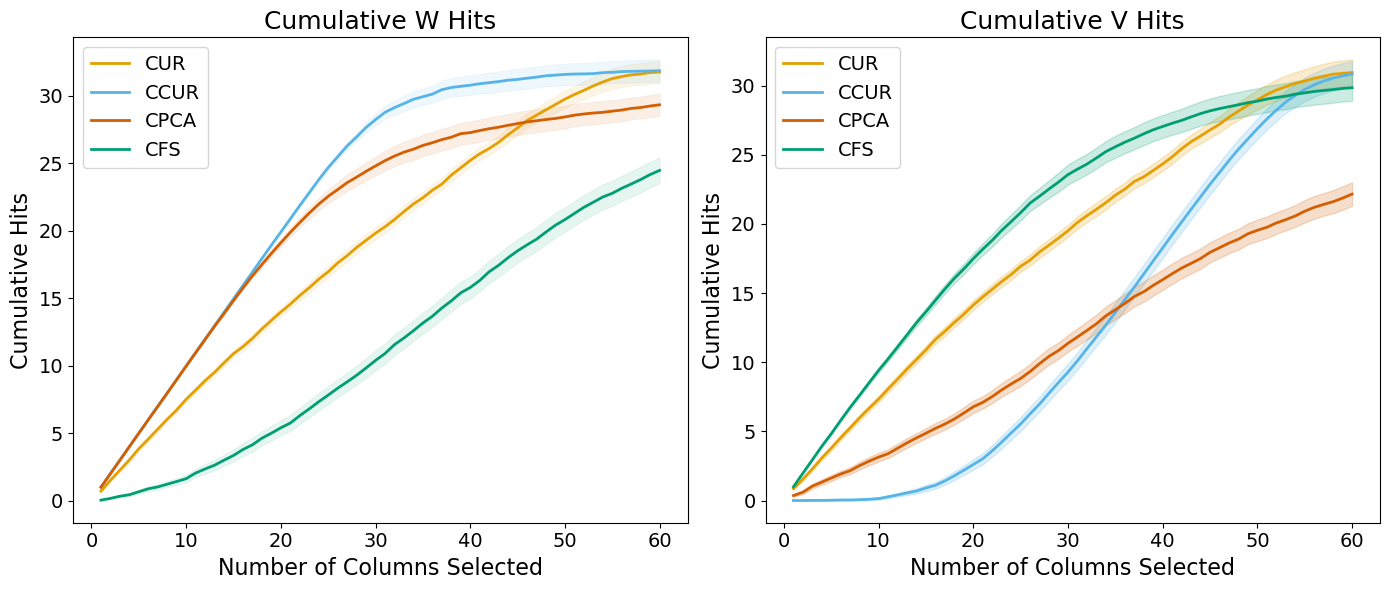

In [18]:
x = np.arange(1, 61)  

colors = {
    'CUR':   '#E69F00',
    'CCUR':  '#56B4E9',
    'CPCA':  '#D55E00',
    'CFS':   '#009E73',
}

methods = ['CUR', 'CCUR', 'CPCA', 'CFS']
mean_W = {
    'CUR': mean_W_cur,
    'CCUR': mean_W_ccur,
    'CPCA': mean_W_cpca,
    'CFS': mean_W_cfs,
}
mean_V = {
    'CUR': mean_V_cur,
    'CCUR': mean_V_ccur,
    'CPCA': mean_V_cpca,
    'CFS': mean_V_cfs,
}

for method in methods:
    mean_W[method] = mean_W[method][:60]
    mean_V[method] = mean_V[method][:60]
    W_bands[method] = (W_bands[method][0][:60], W_bands[method][1][:60])
    V_bands[method] = (V_bands[method][0][:60], V_bands[method][1][:60])


title_fontsize = 18
axis_fontsize = 16
tick_fontsize = 14
legend_fontsize = 14

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
for method in methods:
    plt.plot(x, mean_W[method], label=method, color=colors[method], linewidth=2)
    lower, upper = W_bands[method]
    plt.fill_between(
    x, lower, upper,
    color=colors[method],
    alpha=0.1,                  
    edgecolor=colors[method],  
    linewidth=0.5              
)

plt.title("Cumulative W Hits", fontsize=title_fontsize)
plt.xlabel("Number of Columns Selected", fontsize=axis_fontsize)
plt.ylabel("Cumulative Hits", fontsize=axis_fontsize)
plt.xticks(fontsize=tick_fontsize)
plt.yticks(fontsize=tick_fontsize)
plt.legend(fontsize=legend_fontsize)

plt.subplot(1, 2, 2)
for method in methods:
    plt.plot(x, mean_V[method], label=method, color=colors[method], linewidth=2)
    lower, upper = V_bands[method]
    plt.fill_between(x, lower, upper, color=colors[method], alpha=0.2)
plt.title("Cumulative V Hits", fontsize=title_fontsize)
plt.xlabel("Number of Columns Selected", fontsize=axis_fontsize)
plt.ylabel("Cumulative Hits", fontsize=axis_fontsize)
plt.xticks(fontsize=tick_fontsize)
plt.yticks(fontsize=tick_fontsize)
plt.legend(fontsize=legend_fontsize)

plt.tight_layout()
plt.savefig("column_simulation_error_bars.png", dpi=300, bbox_inches='tight')
plt.show()
